# Colour Grading

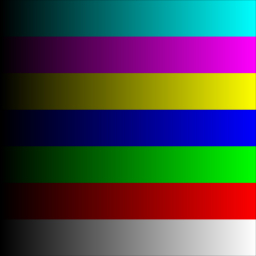

In [ ]:
% matplotlib inline

from __future__ import division

import IPython.display
import IPython.html.widgets
import PIL.Image
import numpy as np
import scipy.ndimage
from cStringIO import StringIO
import warnings

import colour
from colour.models.rgb.deprecated import RGB_to_HSV, HSV_to_RGB
from colour.plotting import *

warnings.filterwarnings('ignore')

LUMINANCE_FACTORS = np.array([0.2126, 0.7152, 0.0722])

IMAGE = colour.read_image('resources/images/Bands.exr')[..., 0:3]


def array_plot(a, fmt='png'):
    buffer = StringIO()

    PIL.Image.fromarray(np.uint8(np.clip(a, 0, 1) * 255)).save(buffer, fmt)
    IPython.display.display(IPython.display.Image(data=buffer.getvalue()))


def lerp(a, b, c):
    return (1 - c) * a + c * b
    

def normal_distribution_function(a, mu=0.5, sigma=0.15):
    a = np.asarray(a)

    return np.exp(-np.power(a - mu, 2) / (2 * np.power(sigma, 2)))


def contrast(a, contrast=1, pivot=0.18):
    a = np.asarray(a)
    contrast = np.asarray(contrast)
    pivot = np.asarray(pivot)
    
    return ((a / pivot) ** contrast) * pivot


def glog(a, gain=1, lift=0, offset=0, gamma=1):
    a = np.asarray(a)
    gain = np.asarray(gain)
    lift = np.asarray(lift)
    offset = np.asarray(offset)
    gamma = np.asarray(gamma)

    a_o = (gain * a + offset + lift * (1 - a)) ** (1 / gamma)

    return a_o


def saturation(a,
               saturation=1,
               luminance_factors=LUMINANCE_FACTORS):
    a = np.asarray(a)
    saturation = np.asarray(saturation)

    return lerp(a, np.dot(a, luminance_factors)[..., np.newaxis], 1 - saturation)


def hue_rotate(a, angle):
    H, S, V = colour.tsplit(RGB_to_HSV(a))

    angle = angle / 360

    H += angle
    H[H > 1] -= 1
    H[H < 0] += 1

    return HSV_to_RGB(colour.tstack((H, S, V)))


def colour_corrector(a,
                     saturation_master=1,
                     contrast_master=1,
                     gain_master=1,
                     lift_master=0,
                     offset_master=0,
                     gamma_master=1,
                     saturation_shadows=1,
                     contrast_shadows=1,
                     gain_shadows=1,
                     lift_shadows=0,
                     offset_shadows=0,
                     gamma_shadows=1,
                     saturation_midtones=1,
                     contrast_midtones=1,
                     gain_midtones=1,
                     lift_midtones=0,
                     offset_midtones=0,
                     gamma_midtones=1,
                     saturation_highlights=1,
                     contrast_highlights=1,
                     gain_highlights=1,
                     lift_highlights=0,
                     offset_highlights=0,
                     gamma_highlights=1,
                     shadows_range=(0, 0.15),
                     highlights_range=(1, 0.15),
                     luminance_factors=LUMINANCE_FACTORS):
    Y = np.dot(a, luminance_factors)

    s_m = normal_distribution_function(Y, *shadows_range)
    h_m = normal_distribution_function(Y, *highlights_range)
    m_m = (1 - (s_m + h_m))

    i_m = glog(saturation(contrast(a, contrast_master), saturation_master, luminance_factors),
                 gain_master, lift_master, offset_master, gamma_master)

    i_o = glog(saturation(contrast(i_m, contrast_shadows), saturation_shadows, luminance_factors),
               gain_shadows, 
               lift_shadows, 
               offset_shadows, 
               gamma_shadows) *  s_m[..., np.newaxis]

    i_o += glog(saturation(contrast(i_m, contrast_midtones), saturation_midtones, luminance_factors),
                gain_midtones, 
                lift_midtones, 
                offset_midtones,
                gamma_midtones) * m_m[..., np.newaxis]

    i_o += glog(saturation(contrast(i_m, contrast_highlights), saturation_highlights, luminance_factors),
                gain_highlights, 
                lift_highlights, 
                offset_highlights,
                gamma_highlights) * h_m[..., np.newaxis]

    return i_o


def colour_corrector_interactive(a,
                                 saturation_master=1,
                                 contrast_master=1,
                                 gain_master=1,
                                 lift_master=0,
                                 offset_master=0,
                                 gamma_master=1,
                                 saturation_shadows=1,
                                 contrast_shadows=1,
                                 gain_shadows=1,
                                 lift_shadows=0,
                                 offset_shadows=0,
                                 gamma_shadows=1,
                                 saturation_midtones=1,
                                 contrast_midtones=1,
                                 gain_midtones=1,
                                 lift_midtones=0,
                                 offset_midtones=0,
                                 gamma_midtones=1,
                                 saturation_highlights=1,
                                 contrast_highlights=1,
                                 gain_highlights=1,
                                 lift_highlights=0,
                                 offset_highlights=0,
                                 gamma_highlights=1,
                                 s_ranges=0.15,
                                 h_ranges=0.15):
    array_plot(colour_corrector(
        a,
        saturation_master, contrast_master, gain_master, lift_master, offset_master, gamma_master, 
        saturation_shadows, contrast_shadows, gain_shadows, lift_shadows, offset_shadows, gamma_shadows, 
        saturation_midtones, contrast_midtones, gain_midtones, lift_midtones, offset_midtones, gamma_midtones,
        saturation_highlights, contrast_highlights, gain_highlights, lift_highlights, offset_highlights, gamma_highlights,
        shadows_range=(0, s_ranges), highlights_range=(1, h_ranges)))


colour_corrector_widget = IPython.html.widgets.interactive(
    colour_corrector_interactive,
    a=IPython.html.widgets.fixed(IMAGE),
    saturation_master=(0, 1, 0.01),
    contrast_master=(0, 2, 0.01),
    gain_master=(-5, 5, 0.01),
    lift_master=(-5, 5, 0.01),
    offset_master=(-5, 5, 0.01),
    gamma_master=(0.01, 4, 0.01),
    saturation_shadows=(0, 1, 0.01),
    contrast_shadows=(0, 2, 0.01),
    gain_shadows=(-5, 5, 0.01),
    lift_shadows=(-5, 5, 0.01),
    offset_shadows=(-5, 5, 0.01),
    gamma_shadows=(0.01, 4, 0.01),
    saturation_midtones=(0, 1, 0.01),
    contrast_midtones=(0, 2, 0.01),
    gain_midtones=(-5, 5, 0.01),
    lift_midtones=(-5, 5, 0.01),
    offset_midtones=(-5, 5, 0.01),
    gamma_midtones=(0.01, 4, 0.01),
    saturation_highlights=(0, 1, 0.01),
    contrast_highlights=(0, 2, 0.01),
    gain_highlights=(-5, 5, 0.01),
    lift_highlights=(-5, 5, 0.01),
    offset_highlights=(-5, 5, 0.01),
    gamma_highlights=(0.01, 4, 0.01),
    s_ranges=(0.01, 1, 0.01),
    h_ranges=(0.01, 1, 0.01))


categories = ('master', 'shadows', 'midtones', 'highlights', 'ranges')
tab_widgets = []
for category in categories:
    widgets = []
    for widget in colour_corrector_widget.children:
        if category in widget.description:
            widget.description = widget.description.split('_')[0].title()
            widgets.append(widget)
    
    tab_widgets.append(IPython.html.widgets.Box(children=widgets))

tab_widget = IPython.html.widgets.Tab(children=tab_widgets)
IPython.display.display(tab_widget)
for i in range(len(categories)):
    tab_widget.set_title(i, categories[i].title())

colour_corrector_widget.children = ()
IPython.display.display(colour_corrector_widget)

In [ ]:
import pylab
from sympy.solvers import solve
from sympy import Eq, Symbol


def tonemapping_operator_Hottes2016(RGB, contrast, shoulder, b, c):
    RGB = np.asarray(RGB)

    z = RGB ** contrast

    return z / (z ** shoulder * b + c)


CONTRAST = 1.25
SHOULDER = 0.9

B = Symbol('b')
C = Symbol('c')


f = lambda x: x ** CONTRAST / (x ** CONTRAST ** SHOULDER * B + C)

solutions = solve((Eq(f(0.18), 0.35), Eq(f(1), 0.8)), B, C)

print(solutions)

samples = np.linspace(0, 1, 100)

pylab.plot(
    samples,
    tonemapping_operator_Hottes2016(
        samples, CONTRAST, SHOULDER, solutions[B], solutions[C]))
pylab.plot(samples, colour.oetf_BT709(samples))

In [ ]:
def generate_RGB_tiles(size=128, repeat=4):
    samples = np.linspace(0, 1, size)
    R, G = np.meshgrid(samples, samples)
    B = np.zeros(R.shape)
    square = colour.tstack((R, G, B))
    
    tiles = np.tile(square, (repeat, repeat, 1))    
    
    B = np.linspace(0, 1, repeat * repeat).reshape((repeat, repeat))
    
    tiles[..., 2] = scipy.ndimage.zoom(B, size)
    
    return tiles


tiles = generate_RGB_tiles() * 5
array_plot(tiles)

tiles_t = tonemapping_operator_Hottes2016(tiles, CONTRAST, SHOULDER, float(solutions[B]), float(solutions[C]))
array_plot(tiles_t)

In [ ]:
def physical_camera(a, FNumber=2.8, ExposureTime=1, ISO=100):
    a = np.asarray(a)
    
    EV = np.log2(FNumber ** 2) + np.log2(1 / ExposureTime) + np.log2(100 / ISO)
    
    return a * (1 / 2 ** EV)


def physical_camera_interactive(a, 
                                FNumber=2.8, 
                                ExposureTime=1, 
                                ISO=100):
    array_plot(physical_camera(a, FNumber, ExposureTime, ISO))

    

IPython.html.widgets.interactive(
    physical_camera_interactive,
    a=IPython.html.widgets.fixed(IMAGE),
    FNumber=(1, 22, 0.1),
    ExposureTime=(0.01, 30, 0.01),   
    ISO=(50, 1600, 50))